In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

In [2]:
## Load data
with open('../data/pickled_data/AEK201_short.pkl', 'rb') as f:
    df = pickle.load(f)

## Grab desired columns
df = df[['date', 'avg_well_depth', 'gage_ht', 'discharge_cfs', 'prcp',
       'temp_avg', 'temp_max', 'temp_min', 'hPa_avg', 'hum_avg', 'hum_max',
       'hum_min', 'wind_avg', 'wind_max', 'wind_min', 'gust_avg', 'gust_max']]

## Pop off date_time information
date_time = pd.to_datetime(df.pop('date'), format='%d.%m.%Y %H:%M:%S')

## Add _time of year_ signal
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

# Training And Holdout Data

Lets save save the final year of data as a holdout set, and use the rest for model training and cross validation.

In [3]:
date_time_holdout = date_time[-365:].copy()
df_holdout = df[-365:].copy()

date_time = date_time[:-365].copy()
df = df[:-365].copy()

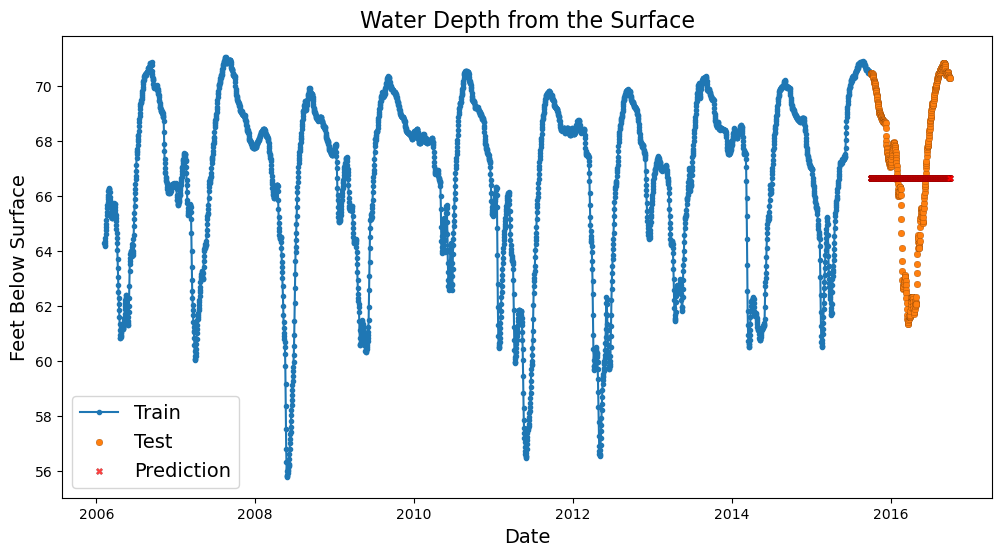

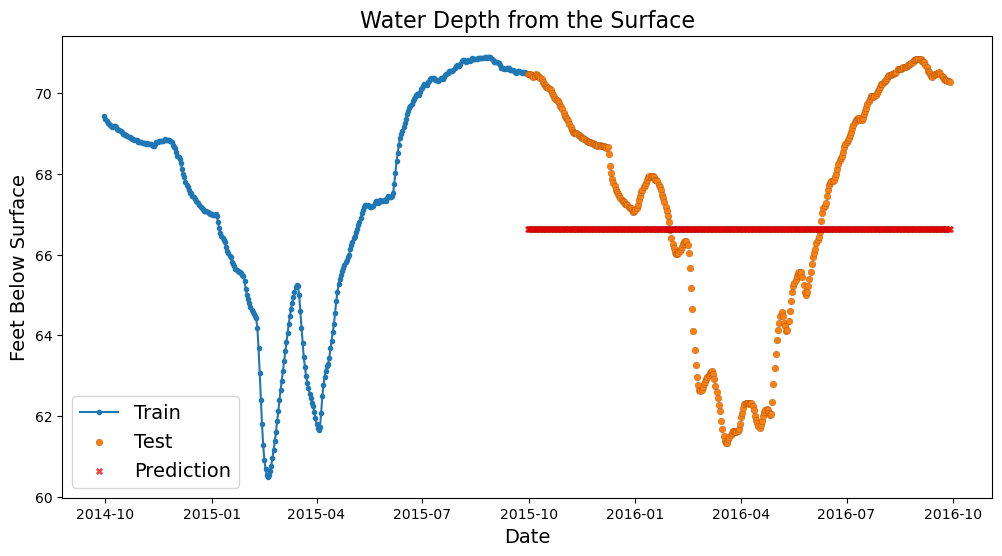

In [4]:
## Grab some practice data for plotting
TEST_SIZE = 365
time_train = date_time[:-TEST_SIZE].copy()
time_test = date_time[-TEST_SIZE:].copy()
data_train = df[:-TEST_SIZE].copy()
data_test = df[-TEST_SIZE:].copy()

## Pediction using the mean of the training data
pred = np.ones(len(data_test))*data_train.avg_well_depth.mean()

## Plot the training data, the test data, and the model prediction
## limiting the length of training data displayed to make the graph
## prettier
def plot(time_train=time_train, time_test=time_test, 
         data_train=data_train, data_test=data_test, 
         pred=pred, train_limit=None, normalized=False):
    
    if train_limit==None:
        train_limit = len(time_train)
    
    plt.figure(figsize=(12,6))

    ## Plot the training data
    plt.plot(time_train[-train_limit:],
             data_train.avg_well_depth[-train_limit:],
             label='Train', 
             marker='.', 
             zorder=-10)

    ## Plot the test data
    plt.scatter(time_test, data_test.avg_well_depth,
                    edgecolors='k',
                    linewidth=0.1,
                    c='#ff7f0e', 
                    alpha =1,
                    s=24,
                    label='Test')
    
    ## Plot the prediction
    plt.scatter(time_test, pred,
                    marker='X',
                    edgecolors='k',
                    linewidth=0.1,
                    c='red', 
                    alpha =.75,
                    s=24,
                    label='Prediction')
    
    if normalized:
        plt.title('Water Depth from the Surface [Normalized]', fontsize = 16)
        plt.ylabel('Feet Below Surface [Normalized]', fontsize=14)
    else:    
        plt.title('Water Depth from the Surface', fontsize = 16)
        plt.ylabel('Feet Below Surface', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.legend(fontsize = 14)

    plt.show()

plot()
plot(train_limit=365)

# Making Models

To get a idea for the steps we'll want to biuld into a pipeline, lets start by building and evaluating a couple of baseline models.

For each of these we will:
1. Split the data into a training set and a test set
2. Normalize the data
3. Fit the model
4. Make predictions
5. Score the model

## Baselines

### Training mean
Predictions for future values will be the mean of the training data.

In [5]:
## Split the data
TEST_SIZE = 365
time_train = date_time[:-TEST_SIZE].copy()
time_test = date_time[-TEST_SIZE:].copy()
data_train = df[:-TEST_SIZE].copy()
data_test = df[-TEST_SIZE:].copy()

In [6]:
## Normalize the data
train_mean = data_train.mean()
train_std = data_train.std()

data_train = ((data_train-train_mean)/train_std).copy()
data_test = ((data_test-train_mean)/train_std).copy()

In [7]:
## Predict the average

## Fit the model
pred_avg = np.ones(len(data_test))*data_train.avg_well_depth.mean()

In [8]:
## Score the model
score_avg = mean_squared_error(data_test.avg_well_depth.values, pred_avg)
score_avg

0.8819923800703847

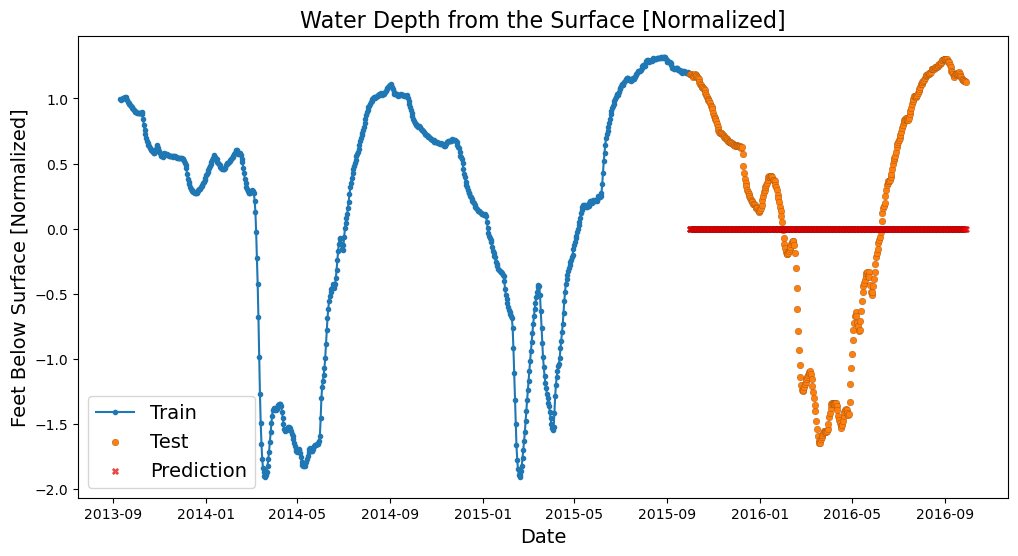

In [9]:
plot(time_train=time_train, time_test=time_test, 
         data_train=data_train, data_test=data_test, 
         pred=pred_avg, train_limit=750, normalized=True)

### Linear Regression
Prediction for the future will be based on a linear regression model fit to the training data.

In [10]:
## Linear Model

## Create an instance of the LinearRegression class
linear = LinearRegression(copy_X=True)

## Fit the model to the training data
X_train = data_train.drop('avg_well_depth', axis=1).values
y_train = data_train.avg_well_depth.values

linear.fit(X_train, y_train)

## Make predictions on the test data
X_test = data_test.drop('avg_well_depth', axis=1).values
pred_lin = linear.predict(X_test)

In [11]:
score_lin = mean_squared_error(data_test.avg_well_depth.values, pred_lin)
score_lin

0.01790385058987343

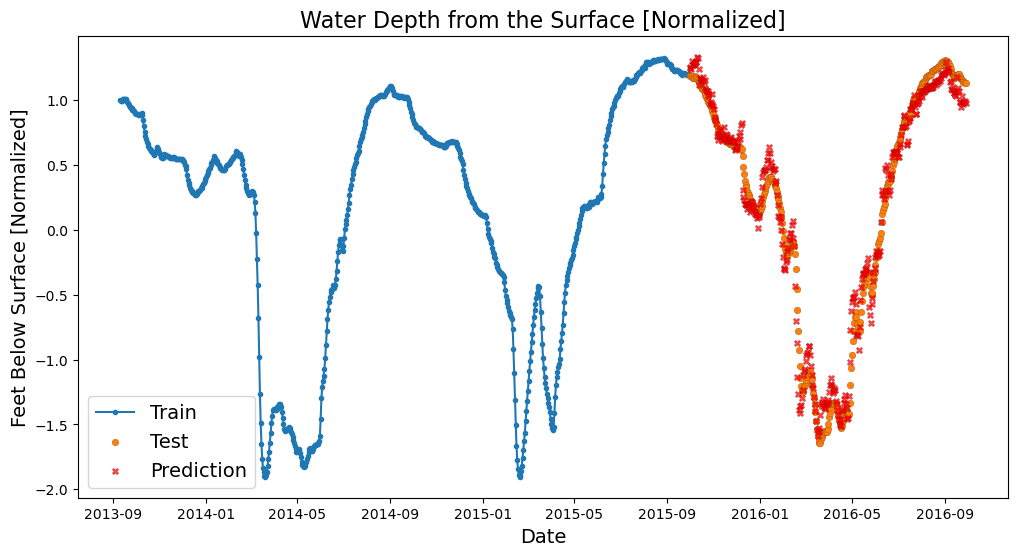

In [12]:
plot(time_train=time_train, time_test=time_test, 
         data_train=data_train, data_test=data_test, 
         pred=pred_lin, train_limit=750, normalized=True)

# Cross Validation

Now that we have a couple of basic models, lets use cross validation to observe how they perform across various traiing and test sets.

In [13]:
## For splitting the data
N_SPLITS = 5
splitter = TimeSeriesSplit(n_splits=N_SPLITS, test_size=365, gap=0)

## For scaling the data
scaler =  StandardScaler(copy=True)

## Baseline Models
### Predict the Average
First, lets look at our "predict the average" model.

In [14]:
mses_avg = np.zeros(N_SPLITS)
i = 0
for train, test in splitter.split(data_train):
    ## Split the data
    d_tt = data_train.iloc[train]
    d_ho = data_train.iloc[test]

    ## Scale the data
    scaler.fit(d_tt)
    tt_scaled = scaler.transform(d_tt)
    ho_scaled = scaler.transform(d_ho)

    ## Fit the model
    pred_avg = np.ones(len(ho_scaled))*tt_scaled[:,0].mean()

    ## Score the model
    score_avg = mean_squared_error(ho_scaled[:,0], pred_avg)
    mses_avg[i] = score_avg
    
    i += 1

In [15]:
print(f'This predict-the-mean model displays an average cross validation mean squared error of: {np.mean(mses_avg)}')

This predict-the-mean model displays an average cross validation mean squared error of: 1.1415967631646426


### Linear Regression

Now, lets look at our linear regression model.

In [16]:
mses_lin = np.zeros(N_SPLITS)
i = 0
for train, test in splitter.split(data_train):
    ## Split the data
    d_tt = data_train.iloc[train]
    d_ho = data_train.iloc[test]

    ## Scale the data
    scaler.fit(d_tt)
    tt_scaled = scaler.transform(d_tt)
    ho_scaled = scaler.transform(d_ho)

    ## Fit the model
    pred_lin = np.ones(len(ho_scaled))*tt_scaled[:,0].mean()

    ## Create an instance of the LinearRegression class
    linear = LinearRegression(copy_X=True)
    
    ## Fit the model to the training data
    X_train = tt_scaled[:,1:]
    y_train = tt_scaled[:,0]
    
    linear.fit(X_train, y_train)
    
    ## Make predictions on the test data
    X_test = ho_scaled[:,1:]
    pred_lin = linear.predict(X_test)

    ## Score the model
    score_lin = mean_squared_error(ho_scaled[:,0], pred_lin)
    mses_lin[i] = score_lin
    
    i += 1

In [17]:
print(f'This linear regression model displays an average cross validation mean squared error of: {np.mean(mses_lin)}')

This linear regression model displays an average cross validation mean squared error of: 0.03602100465520986
